## V2 of the training notebook for GANs

In [1]:
# imports
%load_ext autoreload
%autoreload 2

import os
import pathlib
import torch
import torch.nn as nn
import numpy as np
from torchinfo import summary

from ml_benchmark_spategan.config import config
from ml_benchmark_spategan.dataloader import dataloader
from ml_benchmark_spategan.model.spagan2d import Generator, Discriminator, train_gan_step
from ml_benchmark_spategan.visualization.plot_train import plot_adversarial_losses, plot_predictions, plot_predictions_grid

from diffusers import UNet2DModel
from tqdm import tqdm

from IPython.display import clear_output

### Load configuration and initialize run directory


In [2]:
# find project base directory
project_base = pathlib.Path(os.getcwd()).parent
# load configuration
cf = config.set_up_run(project_base)

2025-12-09 17:50:26 - ml_benchmark_spategan.config.config - INFO - Configuration:
data:
  domain: SA
  training_experiment: ESD_pseudo_reality
  data_path: /bg/fast/aihydromet/cordexbench/
  var_target: tasmax
  normalization: minus1_to_plus1
  num_workers: 4
training:
  batch_size: 32
  epochs: 40
  learning_rate: 0.0001
  optimizer: AdamW
  scheduler: null
  early_stopping: true
  patience: 10
  checkpoint_dir: checkpoints
model:
  architecture: diffusion_unet
  filter_size: 96
  n_input_channels: 15
  n_output_channels: 1
  dropout_seed: 42
  dropout_ratio: 0.2
evaluation:
  metrics:
  - rmse
  output_dir: results
logging:
  level: INFO
  log_dir: logs
  wandb: false
  log_frequency: 1
  checkpoint_frequency: 20
  map_frequency: 1

2025-12-09 17:50:26 - ml_benchmark_spategan.config.config - INFO - Run ID: 20251209_1750_n5aagspg
2025-12-09 17:50:26 - ml_benchmark_spategan.config.config - INFO - Configuration saved to: /bg/fast/env_glawion-l/uvprojects/ml-benchmark-spategan/runs/20251

### Build dataloaders

In [3]:
dataloader_train, test_dataloader, cf = dataloader.build_dataloaders(cf)
# dataloader_train, test_dataloader = dataloader.build_dummy_dataloaders()
# update cf in run directory
cf.save()
# describe shapes of data
print("Training data shapes:")
x_shape, y_shape = dataloader_train.dataset._get_shapes()
print(f"  x: {x_shape}")
print(f"  y: {y_shape}")

2025-12-09 17:50:27 - ml_benchmark_spategan.config.config - INFO - Configuration saved to: /bg/fast/env_glawion-l/uvprojects/ml-benchmark-spategan/runs/20251209_1750_n5aagspg/config.yaml


Training data shapes:
  x: torch.Size([15, 16, 16])
  y: torch.Size([16384])


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

match cf.model.architecture:
    case "spategan":
        print("Using SpaGAN architecture")
        # Initialize models
        generator = Generator(cf.model).to(device)

        # Print model summaries
        print("Generator architecture:")
        summary(generator, input_size=(1, 15, 16, 16))
    case "diffusion_unet":
        print("Using Diffusion UNet architecture")
        generator = UNet2DModel(
                sample_size=(128, 128),
                in_channels=15+1,  # +1 == noise
                out_channels=1,
                layers_per_block=2,
                block_out_channels=(64, 128, 128, 256),
                down_block_types=("DownBlock2D", "DownBlock2D", "DownBlock2D", "AttnDownBlock2D"),
                up_block_types=("UpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
            ).to(device)


    case _:
        raise ValueError(f"Invalid option: {cf.model.architecture}")

Using Diffusion UNet architecture


In [5]:

discriminator = Discriminator(cf).to(device)
print("\nDiscriminator architecture:")
# Note: Discriminator takes (high_res_target, low_res_input)
summary(discriminator, input_size=[(1, 1, 128, 128), (1, 15, 16, 16)])


Discriminator architecture:


Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [1, 1, 4, 4]              --
├─ResidualBlock2D: 1-1                   [1, 128, 128, 128]        --
│    └─Conv2d: 2-1                       [1, 128, 128, 128]        1,152
│    └─ReLU: 2-2                         [1, 128, 128, 128]        --
│    └─Conv2d: 2-3                       [1, 128, 128, 128]        147,456
│    └─Conv2d: 2-4                       [1, 128, 128, 128]        128
│    └─InstanceNorm2d: 2-5               [1, 128, 128, 128]        --
│    └─ReLU: 2-6                         [1, 128, 128, 128]        --
├─ResidualBlock2D: 1-2                   [1, 128, 64, 64]          --
│    └─Conv2d: 2-7                       [1, 128, 64, 64]          147,456
│    └─InstanceNorm2d: 2-8               [1, 128, 64, 64]          --
│    └─ReLU: 2-9                         [1, 128, 64, 64]          --
│    └─Conv2d: 2-10                      [1, 128, 64, 64]          147,

In [6]:
# Setup training
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Move models to device
generator = generator.to(device)
discriminator = discriminator.to(device)

# Loss function
criterion = nn.BCEWithLogitsLoss()

# Optimizers
gen_opt = torch.optim.AdamW(
    generator.parameters(), 
    lr=cf.training.learning_rate, 
    betas=(0.0, 0.999),
    weight_decay=0.0001
)

disc_opt = torch.optim.AdamW(
    discriminator.parameters(), 
    lr=cf.training.learning_rate, 
    betas=(0.0, 0.999),
    weight_decay=0.0001
)

# For mixed precision training
scaler = torch.amp.GradScaler('cuda')

Using device: cuda


In [7]:
# for diffuser UNET, could later moved to dataloader.
import torch
import torch.nn.functional as F

def upscale_nn(x):
    # x: (15, 16, 16)
    return F.interpolate(
        x, 
        size=(128, 128),
        mode="bilinear"
    )
    
    
def add_noise_channel(x):
    # x: (B, 15, 128, 128)
    noise = torch.randn(
        x.size(0),      # batch
        1,              # 1 noise channel
        x.size(2),      # height = 128
        x.size(3),      # width = 128
        device=x.device # put noise on same device (GPU or CPU)
    )

    return torch.cat([x, noise], dim=1)

Epoch 23/40
  Generator Loss:     0.327190
  Discriminator Loss: 1.371366
  Test Loss (L1):     0.131695
plotting 16


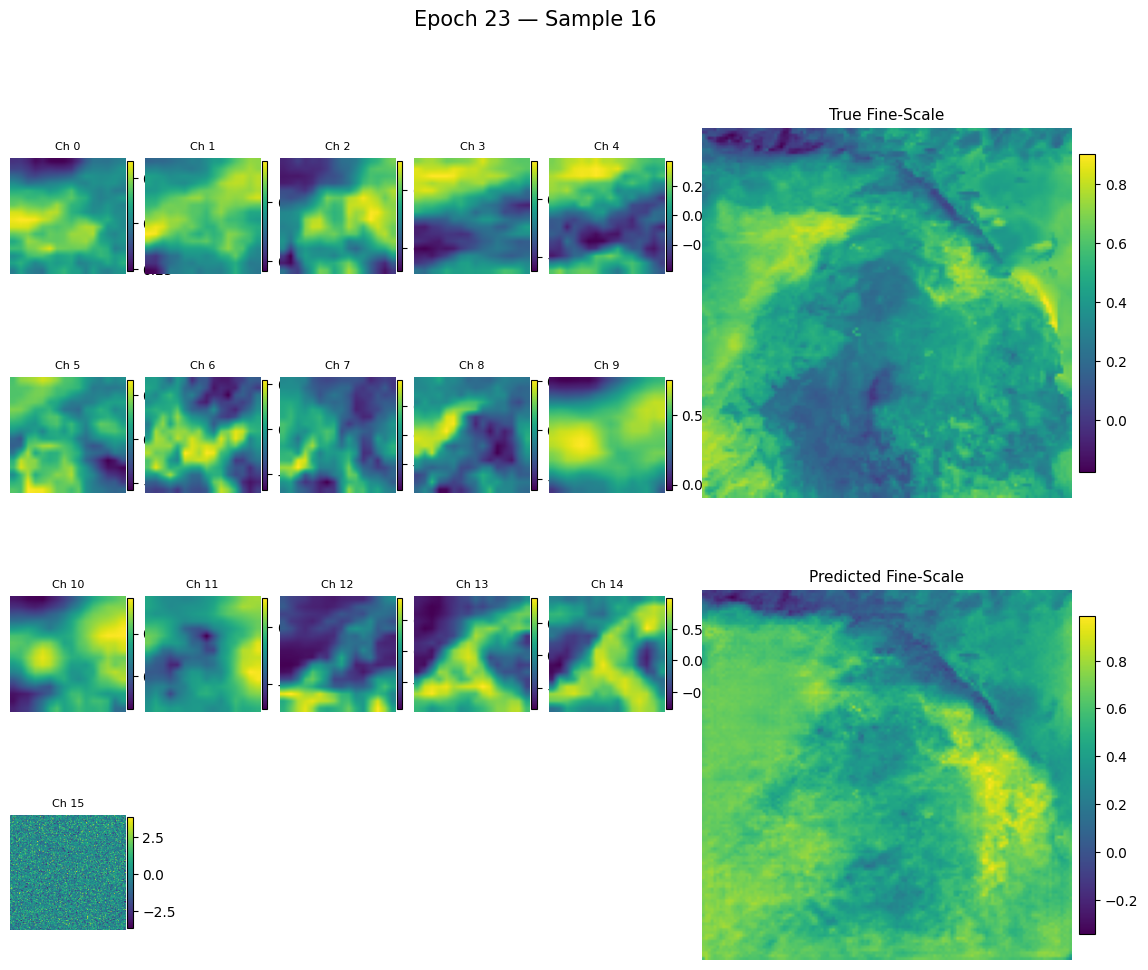

 99%|█████████▉| 158/160 [00:54<00:00,  2.93it/s]

In [ ]:
# GAN Training loop
loss_gen_train = []
loss_disc_train = []
loss_gen_test = []

print(f"Starting GAN training for {cf.training.epochs} epochs...")

# Get a fixed batch for visualization
val_iter = iter(test_dataloader)
x_vis, y_vis = next(val_iter)
x_vis, y_vis = x_vis.to(device), y_vis.to(device)
if cf.model.architecture == "diffusion_unet":
    x_vis = upscale_nn(x_vis)
    x_vis = add_noise_channel(x_vis) # add noise to HR or LR?




for epoch in range(cf.training.epochs):
    # Training phase
    epoch_gen_losses = []
    epoch_disc_losses = []
    
    for batch_idx, (x_batch, y_batch) in tqdm(enumerate(dataloader_train), total=len(dataloader_train)):
        x_batch = x_batch.to(device)
        x_batch_hr = upscale_nn(x_batch) # move to where it is needed, if needed
        # during training, noise channel is added during train step
        y_batch = y_batch.to(device)
        
        # zero timestep, for diffusion UNET.
        timesteps = torch.zeros([x_batch.shape[0]]).to(device) # only for diffusion unet 
        
        # Reshape y_batch to 2D for discriminator
        y_batch_2d = y_batch.view(-1, 1, 128, 128)
        
        # Use the train_gan_step function from spagan2d
        gen_loss, disc_loss = train_gan_step(
            config=cf,
            input_image=x_batch,
            input_image_hr=x_batch_hr,
            target=y_batch_2d,
            step=epoch * len(dataloader_train) + batch_idx,
            discriminator=discriminator,
            generator=generator,
            gen_opt=gen_opt,
            disc_opt=disc_opt,
            scaler=scaler,
            criterion=criterion,
            timesteps=timesteps
        )
        
        epoch_gen_losses.append(gen_loss)
        epoch_disc_losses.append(disc_loss)
    
    # Calculate average training losses
    train_gen_loss = np.mean(epoch_gen_losses)
    train_disc_loss = np.mean(epoch_disc_losses)
    loss_gen_train.append(train_gen_loss)
    loss_disc_train.append(train_disc_loss)
    
    # Validation phase
    generator.eval()
    test_losses = []
    
    with torch.no_grad():
        for x_batch, y_batch in test_dataloader:
            x_batch = x_batch.to(device)
            x_batch_hr = upscale_nn(x_batch)
            x_batch_hr = add_noise_channel(x_batch_hr) # add noise to HR or LR?
            y_batch = y_batch.to(device)
            
            # zero timestep, for diffusion UNET.
            timesteps = torch.zeros([x_batch.shape[0]]).to(device)
            
            with torch.amp.autocast('cuda'):
                match cf.model.architecture:
                    case "spategan":
                        y_pred = generator(x_batch)
                    case "diffusion_unet":
                        y_pred = generator(x_batch_hr, timesteps).sample
                        y_pred = torch.flatten(y_pred, start_dim=1)
                loss = nn.L1Loss()(y_pred, y_batch)
            
            test_losses.append(loss.item())
    
    test_loss = np.mean(test_losses)
    loss_gen_test.append(test_loss)
    
    # Print progress and plot
    if (epoch + 1) % cf.logging.log_frequency == 0 or epoch == 0:
        clear_output(wait=True)
        print(f'Epoch {epoch+1}/{cf.training.epochs}')
        print(f'  Generator Loss:     {train_gen_loss:.6f}')
        print(f'  Discriminator Loss: {train_disc_loss:.6f}')
        print(f'  Test Loss (L1):     {test_loss:.6f}')
        
        # Plot losses
        plot_adversarial_losses(loss_gen_train, loss_disc_train, loss_gen_test, cf)
        
        
    # Save checkpoint
    if (epoch + 1) % cf.logging.checkpoint_frequency == 0:
        torch.save({
            'epoch': epoch + 1,
            'generator_state_dict': generator.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
            'gen_optimizer_state_dict': gen_opt.state_dict(),
            'disc_optimizer_state_dict': disc_opt.state_dict(),
            'train_gen_loss': train_gen_loss,
            'train_disc_loss': train_disc_loss,
            'test_loss': test_loss,
        }, f'{cf.logging.run_dir}/checkpoint_epoch_{epoch+1}.pt')
        print(f'  Checkpoint saved')

    if (epoch + 1) % cf.logging.map_frequency == 0:
        # Visualize predictions
        # plot_predictions(generator, x_vis.to(device), y_vis.to(device), cf, epoch + 1, num_samples=3)
        g = torch.Generator(device="cpu")
        g.seed()  # uses system entropy
        idx = torch.randint(0, x_vis.size(0), (1,), generator=g).item()
        print('plotting', idx)
        plot_predictions_grid(generator, x_vis, y_vis, cf, epoch + 1, device, sample_idx=idx)

# Save final models
torch.save({
    'epoch': cf.training.epochs,
    'generator_state_dict': generator.state_dict(),
    'discriminator_state_dict': discriminator.state_dict(),
    'gen_optimizer_state_dict': gen_opt.state_dict(),
    'disc_optimizer_state_dict': disc_opt.state_dict(),
}, f'{cf.logging.run_dir}/final_models.pt')

print(f'\nGAN training complete! Models saved to {cf.logging.run_dir}')

In [ ]:
# hinge loss test. --> not working



# label smoothing test --> geht, aber disc. stays same

# no noise on disc input: --> same

# random sigma -->